In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np; np.set_printoptions(precision=2); np.random.seed(0)
import torch; torch.set_printoptions(precision=2)
seed = 1

torch.manual_seed(seed)
import torch.nn as nn
import matplotlib.pyplot as plt
# import matplotlib 
from matplotlib.font_manager import FontProperties
from mpl_toolkits import mplot3d
import matplotlib.pylab as pl
from mpltern.ternary.datasets import get_scatter_points


import seaborn as sns
import time
import sys
import itertools 
import random; random.seed(0)
import datetime
import pickle
import copy
import pandas as pd
import scipy; from scipy import stats; from scipy.stats import wilcoxon
import os

from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import sys
sys.path.append("../two_module_rnn/code")
os.chdir('/home/yl4317/Documents/two_module_rnn/code')
# from model_working import *
from functions import *

os.chdir('/home/yl4317/Documents/two_module_rnn/code/code_for_figs')

print(torch.__version__)
print(sys.version)
                
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.13.1+cu116
3.10.8 (main, Nov 24 2022, 14:13:03) [GCC 11.2.0]


# Fig 6e-g Compute the connectivity bias between the sensorimotor populations

# Generate data for computing connectivity biases of the SM recurrent connections

In [8]:
start = time.time()
plot = False

conn_bias_sr_all_models = []

for model_name in sorted(os.listdir('/scratch/yl4317/two_module_rnn/saved_models/')):
    if ('2023-05-10' in model_name) and 'wcst' in model_name and 'success' in model_name:
        print(model_name)
        
        # load model
        path_to_file = '/scratch/yl4317/two_module_rnn/saved_models/'+model_name
        with HiddenPrints():
            model, hp_test, hp_task_test, optim, saved_data = load_model_v2(path_to_file=path_to_file, model_name=model_name, simple=False, plot=False, toprint=False)
        
        # load test data
        with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}'.format(model_name+'_testdata_noiseless_no_current_matrix'), 'rb') as f:
            neural_data = pickle.load(f)
        test_data = neural_data['test_data']
        mean_perf = np.mean([_[0] for _ in test_data['perfs']])
        mean_perf_rule = np.mean([_[0] for _ in test_data['perf_rules']])
        if mean_perf<0.8 or mean_perf_rule<0.8:
            print('low performing model ({}/{})'.format(mean_perf, mean_perf_rule))
            continue
        rnn_activity = neural_data['rnn_activity'].detach().cpu().numpy()

        # generate trial labels
        trial_labels = label_trials_wcst(test_data=test_data)
        resp_trs_stable = {'c1': trial_labels['c1_trs_stable'], 'c2': trial_labels['c2_trs_stable'], 'c3': trial_labels['c3_trs_stable']}
        
        # compute cell selectivity
        all_sels = compute_sel_wcst(rnn_activity=rnn_activity, hp=hp_test, hp_task=hp_task_test, rules=test_data['rules'],
                                     rule1_trs_stable=trial_labels['rule1_trs_stable'], rule2_trs_stable=trial_labels['rule2_trs_stable'],
                                     rule1_trs_after_error = trial_labels['rule1_trs_after_error'], rule2_trs_after_error = trial_labels['rule2_trs_after_error'],
                                     resp_trs_stable=resp_trs_stable, trs_by_center_card=trial_labels['trs_by_center_card_stable'],
                                     stims=test_data['stims'], error_trials=trial_labels['error_trials'], trial_labels=trial_labels)
        rule_sel_used= all_sels['rule_normalized_activity']    
        
        
        resp_sel_normalized = all_sels['resp_normalized']
        rule_sel_normalized = all_sels['rule_normalized_activity']

        # subregions
        subcg_sr_idx = define_subpop_sr_wcst(model=model, hp_task=hp_task_test, hp=hp_test, rnn_activity=rnn_activity, 
                                          rule_sel=all_sels['rule_normalized_activity'], resp_sel=all_sels['resp_normalized'], 
                                          ref_card_sel=all_sels['ref_card_normalized'],
                                          rule1_trs_stable=trial_labels['rule1_trs_stable'], 
                                          rule2_trs_stable=trial_labels['rule2_trs_stable'], 
                                          rule_threshold=0.0, resp_threshold=0.0)
    
        # plot connectivity between subpopulations
        w_rec_eff = model.rnn.effective_weight(w=model.rnn.w_rec, mask=model.rnn.mask, w_fix=model.rnn.w_fix).detach().cpu().numpy()
        if plot==True:    # plot the connectivity matrix between sm populations, if needed
            _, _ = plot_conn_subpop(weight=w_rec_eff, cg_idx=subcg_sr_idx, subcg_to_plot_sender=['rule1_sr_esoma', 'rule2_sr_esoma', 'rule1_sr_pv', 'rule2_sr_pv'], subcg_to_plot_receiver=['rule1_sr_esoma', 'rule2_sr_esoma', 'rule1_sr_pv', 'rule2_sr_pv'])
            
            resp_pops = ['respc1_sr_esoma', 'respc2_sr_esoma', 'respc3_sr_esoma', 'respc1_sr_pv', 'respc2_sr_pv', 'respc3_sr_pv']
            _, _ = plot_conn_subpop(weight=w_rec_eff, cg_idx=subcg_sr_idx, subcg_to_plot_sender=resp_pops, subcg_to_plot_receiver=resp_pops)
            _, _ = plot_conn_subpop(weight=w_rec_eff, cg_idx=subcg_sr_idx, subcg_to_plot_sender=['respc1_sr_pv', 'respc2_sr_pv', 'respc3_sr_pv'], subcg_to_plot_receiver=['respc1_sr_pv', 'respc2_sr_pv', 'respc3_sr_pv'])
            
            shared_feature_pops_color = ['blue_sr_esoma', 'red_sr_esoma', 'blue_sr_pv', 'red_sr_pv']
            _, _ = plot_conn_subpop(weight=w_rec_eff, cg_idx=subcg_sr_idx, subcg_to_plot_sender=shared_feature_pops_color, subcg_to_plot_receiver=shared_feature_pops_color)
            
            shared_feature_pops_shape = ['circle_sr_esoma', 'triangle_sr_esoma', 'circle_sr_pv', 'triangle_sr_pv']
            _, _ = plot_conn_subpop(weight=w_rec_eff, cg_idx=subcg_sr_idx, subcg_to_plot_sender=shared_feature_pops_shape, subcg_to_plot_receiver=shared_feature_pops_shape)
            
        
        
        
        
        # compute connectivity bias for rule
        conn_bias_rulee_rulee = np.mean(w_rec_eff[np.ix_(subcg_sr_idx['rule1_sr_esoma'], subcg_sr_idx['rule1_sr_esoma'])])\
                                  +np.mean(w_rec_eff[np.ix_(subcg_sr_idx['rule2_sr_esoma'], subcg_sr_idx['rule2_sr_esoma'])])\
                                  -np.mean(w_rec_eff[np.ix_(subcg_sr_idx['rule1_sr_esoma'], subcg_sr_idx['rule2_sr_esoma'])])\
                                  -np.mean(w_rec_eff[np.ix_(subcg_sr_idx['rule2_sr_esoma'], subcg_sr_idx['rule1_sr_esoma'])])
        conn_bias_rulee_rulepv = np.mean(w_rec_eff[np.ix_(subcg_sr_idx['rule1_sr_esoma'], subcg_sr_idx['rule1_sr_pv'])])\
                                  +np.mean(w_rec_eff[np.ix_(subcg_sr_idx['rule2_sr_esoma'], subcg_sr_idx['rule2_sr_pv'])])\
                                  -np.mean(w_rec_eff[np.ix_(subcg_sr_idx['rule1_sr_esoma'], subcg_sr_idx['rule2_sr_pv'])])\
                                  -np.mean(w_rec_eff[np.ix_(subcg_sr_idx['rule2_sr_esoma'], subcg_sr_idx['rule1_sr_pv'])])
        conn_bias_rulepv_rulee = np.mean(w_rec_eff[np.ix_(subcg_sr_idx['rule1_sr_pv'], subcg_sr_idx['rule2_sr_esoma'])])\
                                  +np.mean(w_rec_eff[np.ix_(subcg_sr_idx['rule2_sr_pv'], subcg_sr_idx['rule1_sr_esoma'])])\
                                  -np.mean(w_rec_eff[np.ix_(subcg_sr_idx['rule1_sr_pv'], subcg_sr_idx['rule1_sr_esoma'])])\
                                  -np.mean(w_rec_eff[np.ix_(subcg_sr_idx['rule2_sr_pv'], subcg_sr_idx['rule2_sr_esoma'])])
        conn_bias_rulepv_rulee = -conn_bias_rulepv_rulee
        conn_bias_rulepv_rulepv = np.mean(w_rec_eff[np.ix_(subcg_sr_idx['rule1_sr_pv'], subcg_sr_idx['rule2_sr_pv'])])\
                                  +np.mean(w_rec_eff[np.ix_(subcg_sr_idx['rule2_sr_pv'], subcg_sr_idx['rule1_sr_pv'])])\
                                  -np.mean(w_rec_eff[np.ix_(subcg_sr_idx['rule1_sr_pv'], subcg_sr_idx['rule1_sr_pv'])])\
                                  -np.mean(w_rec_eff[np.ix_(subcg_sr_idx['rule2_sr_pv'], subcg_sr_idx['rule2_sr_pv'])])
        conn_bias_rulepv_rulepv = -conn_bias_rulepv_rulepv
        
                     

        # connectivity bias based on neurons preferring different responses              
        conn = {}
        conn[('resp_sr_esoma', 'resp_sr_esoma')] = {}
        conn[('resp_sr_esoma', 'resp_sr_pv')] = {}
        conn[('resp_sr_pv', 'resp_sr_esoma')] = {}
        conn[('resp_sr_pv', 'resp_sr_pv')] = {}
        for key in conn.keys():
            for x in ['same', 'cross']:
                conn[key][x] = []
        
        for resp1 in ['c1', 'c2', 'c3']:
            for resp2 in ['c1', 'c2', 'c3']:
                if resp1==resp2:
                    for sender, receiver in itertools.product(['sr_esoma', 'sr_pv'], repeat=2):
                        conn[('resp_{}'.format(sender), 'resp_{}'.format(receiver))]['same'].append(np.mean(w_rec_eff[np.ix_(subcg_sr_idx['resp{}_{}'.format(resp1, sender)], subcg_sr_idx['resp{}_{}'.format(resp2, receiver)])]))
                elif resp1!=resp2:
                    for sender, receiver in itertools.product(['sr_esoma', 'sr_pv'], repeat=2):
                        conn[('resp_{}'.format(sender), 'resp_{}'.format(receiver))]['cross'].append(np.mean(w_rec_eff[np.ix_(subcg_sr_idx['resp{}_{}'.format(resp1, sender)], subcg_sr_idx['resp{}_{}'.format(resp2, receiver)])]))     
                        
        conn_bias_respe_respe = np.mean(conn[('resp_sr_esoma', 'resp_sr_esoma')]['same']) - np.mean(conn[('resp_sr_esoma', 'resp_sr_esoma')]['cross'])
        conn_bias_respe_resppv = np.mean(conn[('resp_sr_esoma', 'resp_sr_pv')]['same']) - np.mean(conn[('resp_sr_esoma', 'resp_sr_pv')]['cross'])
        conn_bias_resppv_respe = - (np.mean(conn[('resp_sr_pv', 'resp_sr_esoma')]['cross']) - np.mean(conn[('resp_sr_pv', 'resp_sr_esoma')]['same']))
        conn_bias_resppv_resppv = - (np.mean(conn[('resp_sr_pv', 'resp_sr_pv')]['cross']) - np.mean(conn[('resp_sr_pv', 'resp_sr_pv')]['same']))
        
        
        
        # connectivity bias based on neurons preferring different reference cards
        # conn = {}
        # conn[('ref_card_sr_esoma', 'ref_card_sr_esoma')] = {}
        # conn[('ref_card_sr_esoma', 'ref_card_sr_pv')] = {}
        # conn[('ref_card_sr_pv', 'ref_card_sr_esoma')] = {}
        # conn[('ref_card_sr_pv', 'ref_card_sr_pv')] = {}
        # for key in conn.keys():
        #     for x in ['same', 'cross']:
        #         conn[key][x] = []
            
        # for ref_card1 in [(0, 0), (0, 1), (1, 0), (1, 1)]:
        #     for ref_card2 in [(0, 0), (0, 1), (1, 0), (1, 1)]:
        #         if ref_card1==ref_card2:
        #             for sender, receiver in itertools.product(['sr_esoma', 'sr_pv'], repeat=2):
        #                 conn[('ref_card_{}'.format(sender), 'ref_card_{}'.format(receiver))]['same'].append(np.mean(w_rec_eff[np.ix_(subcg_sr_idx['ref_card{}_{}'.format(ref_card1, sender)], subcg_sr_idx['ref_card{}_{}'.format(ref_card2, receiver)])]))
        #         elif ref_card1!=ref_card2:
        #             for sender, receiver in itertools.product(['sr_esoma', 'sr_pv'], repeat=2):
        #                 conn[('ref_card_{}'.format(sender), 'ref_card_{}'.format(receiver))]['cross'].append(np.mean(w_rec_eff[np.ix_(subcg_sr_idx['ref_card{}_{}'.format(ref_card1, sender)], subcg_sr_idx['ref_card{}_{}'.format(ref_card2, receiver)])]))     
                        
        # conn_bias_ref_card_e_ref_card_e = np.mean(conn[('ref_card_sr_esoma', 'ref_card_sr_esoma')]['same']) - np.mean(conn[('ref_card_sr_esoma', 'ref_card_sr_esoma')]['cross'])
        # conn_bias_ref_card_e_ref_card_pv = np.mean(conn[('ref_card_sr_esoma', 'ref_card_sr_pv')]['same']) - np.mean(conn[('ref_card_sr_esoma', 'ref_card_sr_pv')]['cross'])
        # conn_bias_ref_card_pv_ref_card_e = - (np.mean(conn[('ref_card_sr_pv', 'ref_card_sr_esoma')]['cross']) - np.mean(conn[('ref_card_sr_pv', 'ref_card_sr_esoma')]['same']))
        # conn_bias_ref_card_pv_ref_card_pv = - (np.mean(conn[('ref_card_sr_pv', 'ref_card_sr_pv')]['cross']) - np.mean(conn[('ref_card_sr_pv', 'ref_card_sr_pv')]['same']))
        
        
        # connectivity bias based on neurons preferring different reference cards (i.e. shared features)
        conn = {}
        conn[('shared_feature_sr_esoma', 'shared_feature_sr_esoma')] = {}
        conn[('shared_feature_sr_esoma', 'shared_feature_sr_pv')] = {}
        conn[('shared_feature_sr_pv', 'shared_feature_sr_esoma')] = {}
        conn[('shared_feature_sr_pv', 'shared_feature_sr_pv')] = {}
        for key in conn.keys():
            for x in ['same', 'cross']:
                conn[key][x] = []
        
        shared_features = ['blue', 'red', 'circle', 'triangle']
        for f1 in shared_features:
            for f2 in shared_features:
                for sender, receiver in itertools.product(['sr_esoma', 'sr_pv'], repeat=2):
                    mean_weight = np.mean(w_rec_eff[np.ix_(subcg_sr_idx['{}_{}'.format(f1, sender)], subcg_sr_idx['{}_{}'.format(f2, receiver)])])
                    if f1==f2:
                        conn[('shared_feature_{}'.format(sender), 'shared_feature_{}'.format(receiver))]['same'].append(mean_weight)
                    elif f1!=f2 and shared_features.index(f1)//2 == shared_features.index(f2)//2:    # do not include for example f1=blue and f2=square
                        conn[('shared_feature_{}'.format(sender), 'shared_feature_{}'.format(receiver))]['cross'].append(mean_weight)     
                        
        conn_bias_shared_feature_e_e = np.mean(conn[('shared_feature_sr_esoma', 'shared_feature_sr_esoma')]['same']) - np.mean(conn[('shared_feature_sr_esoma', 'shared_feature_sr_esoma')]['cross'])
        conn_bias_shared_feature_e_pv = np.mean(conn[('shared_feature_sr_esoma', 'shared_feature_sr_pv')]['same']) - np.mean(conn[('shared_feature_sr_esoma', 'shared_feature_sr_pv')]['cross'])
        conn_bias_shared_feature_pv_e = - (np.mean(conn[('shared_feature_sr_pv', 'shared_feature_sr_esoma')]['cross']) - np.mean(conn[('shared_feature_sr_pv', 'shared_feature_sr_esoma')]['same']))
        conn_bias_shared_feature_pv_pv = - (np.mean(conn[('shared_feature_sr_pv', 'shared_feature_sr_pv')]['cross']) - np.mean(conn[('shared_feature_sr_pv', 'shared_feature_sr_pv')]['same']))
        
        
        
        
        
        conn_bias_sr_all_models.append({'model': model_name, 
                                        'hp': hp_test,
                                        'bias_ruleesoma_ruleesoma': conn_bias_rulee_rulee, 
                                        'bias_ruleesoma_rulepv': conn_bias_rulee_rulepv, 
                                        'bias_rulepv_ruleesoma': conn_bias_rulepv_rulee, 
                                        'bias_rulepv_rulepv': conn_bias_rulepv_rulepv,
                                        'bias_respesoma_respesoma': conn_bias_respe_respe, 
                                        'bias_respesoma_resppv': conn_bias_respe_resppv, 
                                        'bias_resppv_respesoma': conn_bias_resppv_respe, 
                                        'bias_resppv_resppv': conn_bias_resppv_resppv,
                                        'bias_ref_card_esoma_ref_card_esoma': conn_bias_ref_card_e_ref_card_e, 
                                        'bias_ref_card_esoma_ref_card_pv': conn_bias_ref_card_e_ref_card_pv, 
                                        'bias_ref_card_pv_ref_card_esoma': conn_bias_ref_card_pv_ref_card_e, 
                                        'bias_ref_card_pv_ref_card_pv': conn_bias_ref_card_pv_ref_card_pv,
                                        'bias_shared_feature_esoma_esoma': conn_bias_shared_feature_e_e, 
                                        'bias_shared_feature_esoma_pv': conn_bias_shared_feature_e_pv, 
                                        'bias_shared_feature_pv_esoma': conn_bias_shared_feature_pv_e, 
                                        'bias_shared_feature_pv_pv': conn_bias_shared_feature_pv_pv,
                                       })
        # print('biases: {}'.format(conn_bias_sr_all_models[-1][2:]))

with open('/home/yl4317/Documents/two_module_rnn/processed_data/conn_bias_sm_w_rec.pickle', 'wb') as handle:
        pickle.dump(conn_bias_sr_all_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(time.time()-start)

success_2023-05-10-14-28-42_wcst_105_sparsity0
success_2023-05-10-14-28-42_wcst_106_sparsity0
success_2023-05-10-14-28-42_wcst_10_sparsity0
success_2023-05-10-14-28-42_wcst_112_sparsity0
low performing model (0.0/0.0)
success_2023-05-10-14-28-42_wcst_115_sparsity0
low performing model (0.125/0.02500000037252903)
success_2023-05-10-14-28-42_wcst_116_sparsity0
success_2023-05-10-14-28-42_wcst_118_sparsity0
success_2023-05-10-14-28-42_wcst_121_sparsity0
success_2023-05-10-14-28-42_wcst_122_sparsity0
success_2023-05-10-14-28-42_wcst_124_sparsity0
success_2023-05-10-14-28-42_wcst_126_sparsity0
success_2023-05-10-14-28-42_wcst_131_sparsity0
success_2023-05-10-14-28-42_wcst_134_sparsity0
success_2023-05-10-14-28-42_wcst_136_sparsity0
success_2023-05-10-14-28-42_wcst_139_sparsity0
success_2023-05-10-14-28-42_wcst_142_sparsity0
success_2023-05-10-14-28-42_wcst_143_sparsity0
success_2023-05-10-14-28-42_wcst_144_sparsity0
success_2023-05-10-14-28-42_wcst_149_sparsity0
success_2023-05-10-14-28-42_

# Figure 6e-g and Supplementary Figure 10c-e

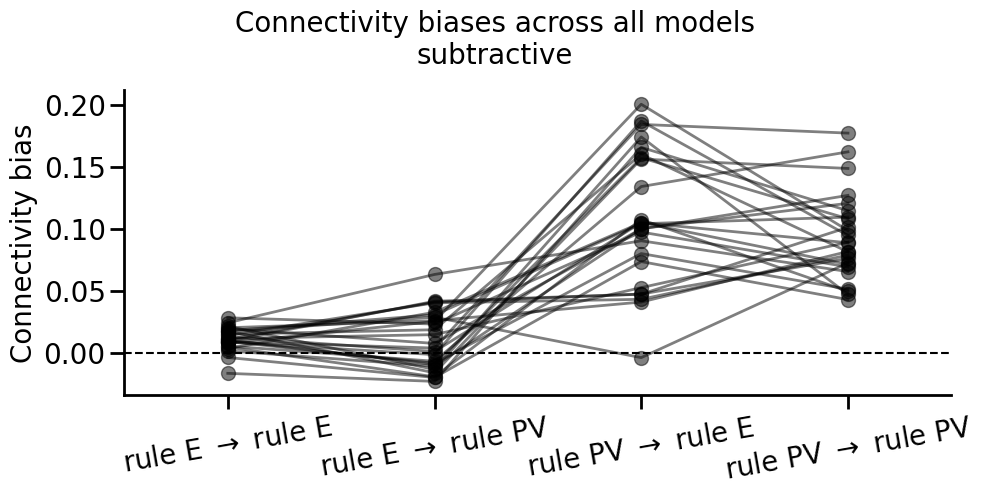

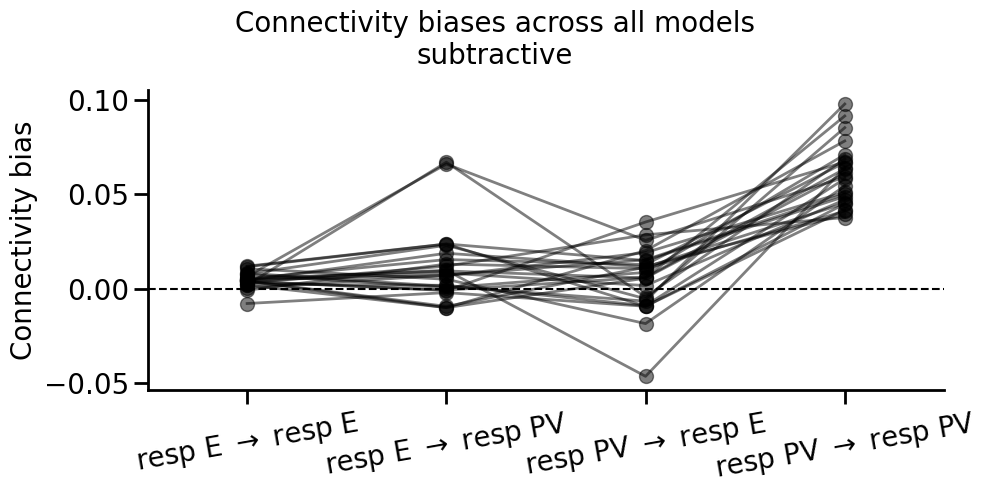

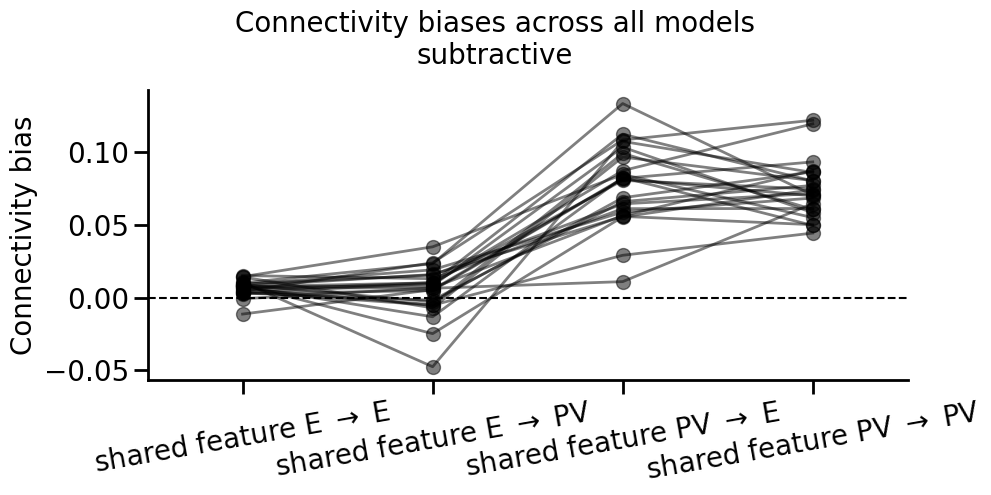

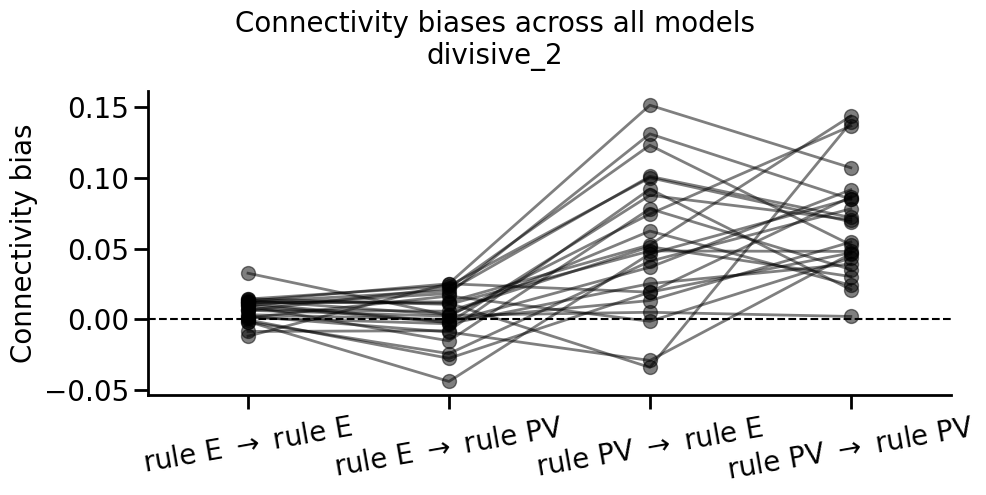

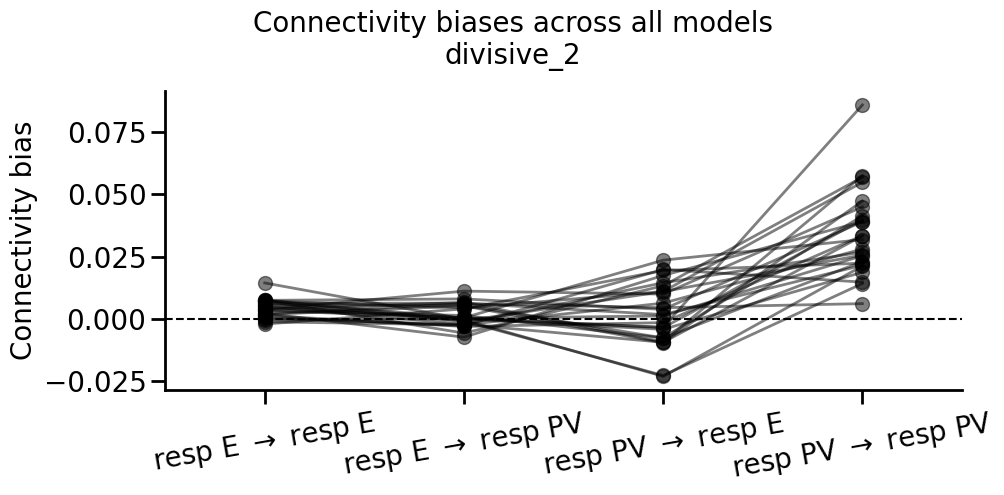

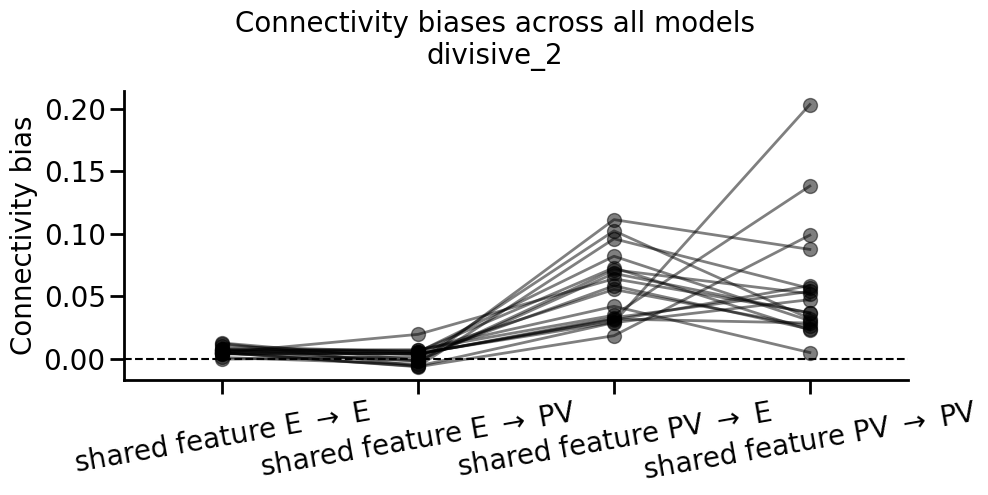

In [13]:
with open('/home/yl4317/Documents/two_module_rnn/processed_data/conn_bias_sm_w_rec.pickle', 'rb') as handle:
    conn_bias_sr_all_models = pickle.load(handle)


data_fig6e = dict.fromkeys(['subtractive', 'divisive_2'])     # connectivity biases between rule-selective populations
for key in data_fig6e.keys():
    data_fig6e[key] = {'exc_exc': [], 'exc_pv': [], 'pv_exc': [], 'pv_pv': []}
    
data_fig6f = dict.fromkeys(['subtractive', 'divisive_2'])    # connectivity biases between response location-selective populations
for key in data_fig6e.keys():
    data_fig6f[key] = {'exc_exc': [], 'exc_pv': [], 'pv_exc': [], 'pv_pv': []}
    
data_fig6g = dict.fromkeys(['subtractive', 'divisive_2'])    # connectivity biases between shared feature-selective populations
for key in data_fig6e.keys():
    data_fig6g[key] = {'exc_exc': [], 'exc_pv': [], 'pv_exc': [], 'pv_pv': []}



for dend_nonlinear in ['subtractive', 'divisive_2']:
    fig, ax = plt.subplots(figsize=[10, 5])
    fig.suptitle('Connectivity biases across all models\n{}'.format(dend_nonlinear), fontsize=20)
    fig.patch.set_facecolor('white')
    for x in conn_bias_sr_all_models:
        if x['hp']['dend_nonlinearity'] != dend_nonlinear:
            continue
        data = list(x.values())[2:6]
        if np.isnan(data).any():
            continue
    
        data_fig6e[dend_nonlinear]['exc_exc'].append(data[0])
        data_fig6e[dend_nonlinear]['exc_pv'].append(data[1])
        data_fig6e[dend_nonlinear]['pv_exc'].append(data[2])
        data_fig6e[dend_nonlinear]['pv_pv'].append(data[3])
    
        
        ax.plot(data, marker='o', color='k', linewidth=2, markersize=10, alpha=0.5, clip_on=False)
    ax.set_xticks(np.arange(len(data)))
    ax.set_xticklabels([r'rule E $\rightarrow$ rule E', r'rule E $\rightarrow$ rule PV', r'rule PV $\rightarrow$ rule E', r'rule PV $\rightarrow$ rule PV'], rotation=10)
    ax.axhline(y=0, ls='--', color='k')
    ax.set_xlim(-0.5, len(data)-0.5)
    # ax.set_ylim(-1,2)
    ax.set_ylabel('Connectivity bias', fontsize=20)
    make_pretty_axes(ax)
    fig.tight_layout()
    plt.show()
    fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/conn_bias_sm_wrec_rule_allNets_{}.pdf'.format(dend_nonlinear))
    
    
    fig, ax = plt.subplots(figsize=[10, 5])
    fig.suptitle('Connectivity biases across all models\n{}'.format(dend_nonlinear), fontsize=20)
    fig.patch.set_facecolor('white')
    for x in conn_bias_sr_all_models:
        if x['hp']['dend_nonlinearity'] != dend_nonlinear:
            continue
        data = list(x.values())[6:10]
        if np.isnan(data).any():
            continue
    
    
        data_fig6f[dend_nonlinear]['exc_exc'].append(data[0])
        data_fig6f[dend_nonlinear]['exc_pv'].append(data[1])
        data_fig6f[dend_nonlinear]['pv_exc'].append(data[2])
        data_fig6f[dend_nonlinear]['pv_pv'].append(data[3])
    
        
        ax.plot(data, marker='o', color='k', linewidth=2, markersize=10, alpha=0.5, clip_on=False)
    ax.set_xticks(np.arange(len(data)))
    ax.set_xticklabels([r'resp E $\rightarrow$ resp E', r'resp E $\rightarrow$ resp PV', r'resp PV $\rightarrow$ resp E', r'resp PV $\rightarrow$ resp PV'], rotation=10)
    ax.axhline(y=0, ls='--', color='k')
    ax.set_xlim(-0.5, len(data)-0.5)
    # ax.set_ylim(-1,2)
    ax.set_ylabel('Connectivity bias', fontsize=20)
    make_pretty_axes(ax)
    fig.tight_layout()
    plt.show()
    fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/conn_bias_sm_wrec_resp_allNets_{}.pdf'.format(dend_nonlinear))
    
    
    fig, ax = plt.subplots(figsize=[10, 5])
    fig.suptitle('Connectivity biases across all models\n{}'.format(dend_nonlinear), fontsize=20)
    fig.patch.set_facecolor('white')
    for x in conn_bias_sr_all_models:
        if x['hp']['dend_nonlinearity'] != dend_nonlinear:
            continue
        data = list(x.values())[14:18]
        if np.isnan(data).any():
            continue
    
        data_fig6g[dend_nonlinear]['exc_exc'].append(data[0])
        data_fig6g[dend_nonlinear]['exc_pv'].append(data[1])
        data_fig6g[dend_nonlinear]['pv_exc'].append(data[2])
        data_fig6g[dend_nonlinear]['pv_pv'].append(data[3])
        
        ax.plot(data, marker='o', color='k', linewidth=2, markersize=10, alpha=0.5, clip_on=False)
    ax.set_xticks(np.arange(len(data)))
    ax.set_xticklabels([r'shared feature E $\rightarrow$ E', r'shared feature E $\rightarrow$ PV', r'shared feature PV $\rightarrow$ E', r'shared feature PV $\rightarrow$ PV'], rotation=10)
    ax.axhline(y=0, ls='--', color='k')
    ax.set_xlim(-0.5, len(data)-0.5)
    # ax.set_ylim(-1,2)
    ax.set_ylabel('Connectivity bias', fontsize=20)
    make_pretty_axes(ax)
    fig.tight_layout()
    plt.show()
    fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/conn_bias_sm_wrec_sharedFeature_allNets_{}.pdf'.format(dend_nonlinear))

    
    # save to csv
    pd.DataFrame.from_dict(data=data_fig6e[dend_nonlinear], orient='index').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/fig6e_conn_bias_sm_rec_{}.csv'.format(dend_nonlinear), header=False)
    pd.DataFrame.from_dict(data=data_fig6f[dend_nonlinear], orient='index').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/fig6f_conn_bias_sm_rec_{}.csv'.format(dend_nonlinear), header=False)
    pd.DataFrame.from_dict(data=data_fig6g[dend_nonlinear], orient='index').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/fig6g_conn_bias_sm_rec_{}.csv'.format(dend_nonlinear), header=False)